In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import scipy

c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [10]:
soundfile_1 = 'Alesis-Fusion-English-Horn-C5.wav'
soundfile_2 = 'Bowed-Bass-C2.wav'

samplerate_1, data_1 = wavfile.read(soundfile_1)
samplerate_2, data_2 = wavfile.read(soundfile_2)

print(np.shape(data_1),np.shape(data_2))

(73412, 2) (148144, 2)


C:\Users\kufuk\AppData\Local\Temp\ipykernel_12480\2709578966.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate_1, data_1 = wavfile.read(soundfile_1)
C:\Users\kufuk\AppData\Local\Temp\ipykernel_12480\2709578966.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate_2, data_2 = wavfile.read(soundfile_2)


In [18]:
data_1 = data_1[:,0]
data_2 = data_2[:,0]

In [11]:
sd.play(data_1, samplerate_1)
sd.wait()
sd.play(data_2, samplerate_2)
sd.wait()

In [15]:
duration_1 = len(data_1) / samplerate_1
time_1 = np.arange(0, duration_1, 1/samplerate_1)

duration_2 = len(data_2) / samplerate_2
time_2 = np.arange(0, duration_2, 1/samplerate_2)

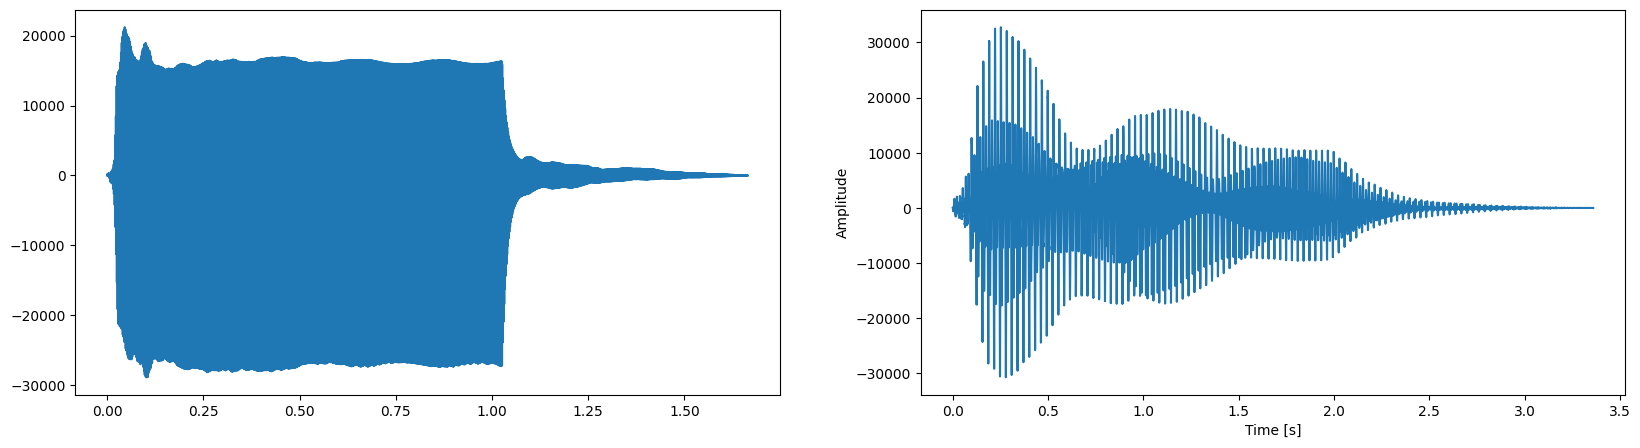

In [19]:
fig, axs = plt.subplots(1, 2 ,figsize=(20, 5))
axs[0].plot(time_1, data_1)
axs[1].plot(time_2, data_2)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

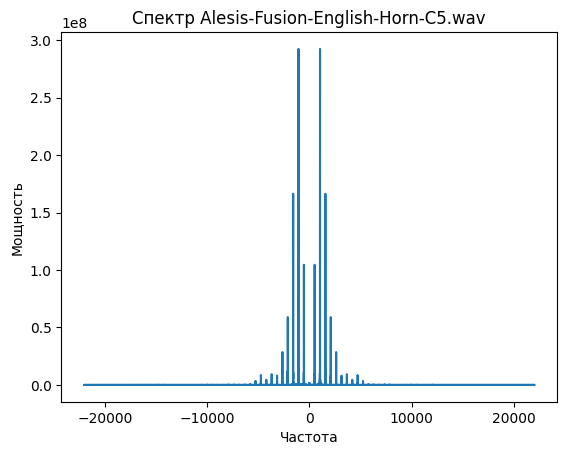

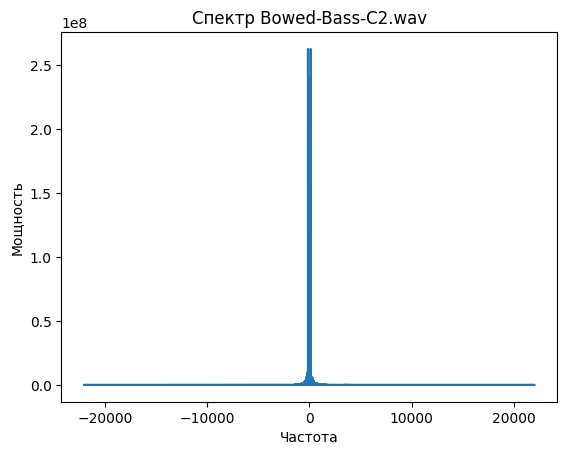

In [20]:
from scipy.fft import fft, fftfreq


N = int(samplerate_1 * duration_1)
yf = fft(data_1)
xf = fftfreq(N, 1 / samplerate_1)
plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.title('Спектр Alesis-Fusion-English-Horn-C5.wav')
plt.show()

N = int(samplerate_2 * duration_2)
yf = fft(data_2)
xf = fftfreq(N, 1 / samplerate_2)
plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.title('Спектр Bowed-Bass-C2.wav')
plt.show()

In [21]:
def B_inv(b):
    return 700 * (np.exp(b / 1125) - 1)

def B(b):
    return 1125 * np.log(1 + b / 700)

def get_filter_points(fmin, fmax, mel_filter_num, wav_size, sample_rate=44100):    
    mels = np.linspace(B(fmin), B(fmax), num=mel_filter_num + 2)
    freqs = B_inv(mels)
    
    return np.floor((wav_size + 1) / sample_rate * freqs).astype(int)

def H(k, m, f):
    if k >= f[m - 1] and k < f[m]:
        return (k - f[m - 1]) / (f[m] - f[m - 1])
    if k >= f[m] and k <= f[m + 1]:
        return (f[m + 1] - k) / (f[m + 1] - f[m])
    return 0

mfccs = []
datas = [data_1, data_2]
rates = [samplerate_1, samplerate_2]

for i in range(len(datas)):
    x = datas[i]
    X = scipy.fft.fft(datas[i])
    M = 30
    N = len(X)

    filters_points = get_filter_points(0, rates[i] / 2, M, N)

    S = []

    for m in range(1, M + 1):
        Si = 0
        for k in range(N - 1):
            Si += (np.abs(X[k]) ** 2) * H(k, m, filters_points)
        S += [np.log(Si)]
    
    c = []

    for n in range(M):
        ci = 0
        for m in range(M):
            ci += S[m] * np.cos(np.pi * n * (m + 0.5) / M)
        c += [ci]
    mfccs += [c]

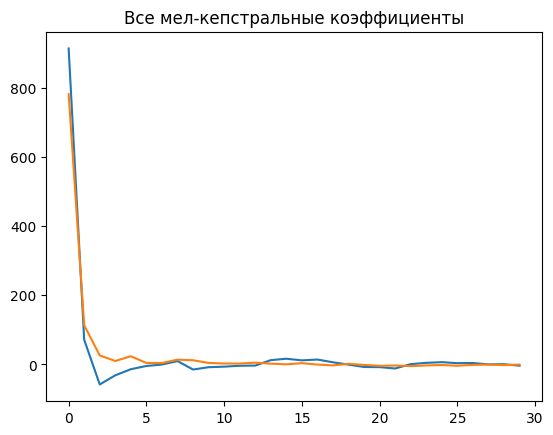

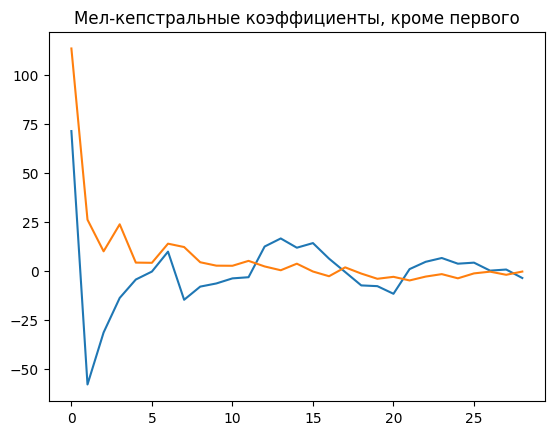

In [23]:
for mfcc in mfccs:
    plt.plot(mfcc)
plt.title('Все мел-кепстральные коэффициенты')
plt.show()

for mfcc in mfccs:
    plt.plot(mfcc[1:])
plt.title('Мел-кепстральные коэффициенты, кроме первого')
plt.show()

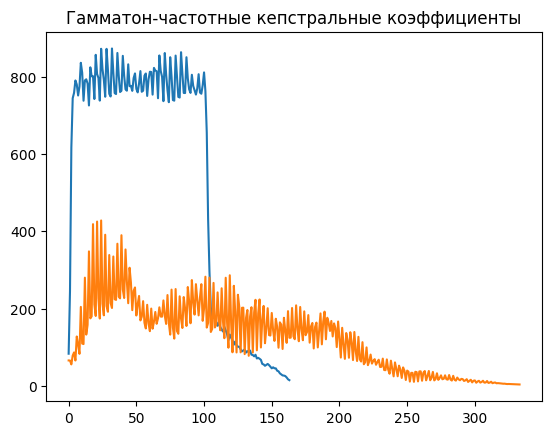

In [24]:
from spafe.features.gfcc import gfcc

for i in range(len(datas)):
    gfccs = gfcc(datas[i], fs=rates[i], num_ceps=1)
    plt.plot(gfccs)
plt.title('Гамматон-частотные кепстральные коэффициенты')
plt.show()

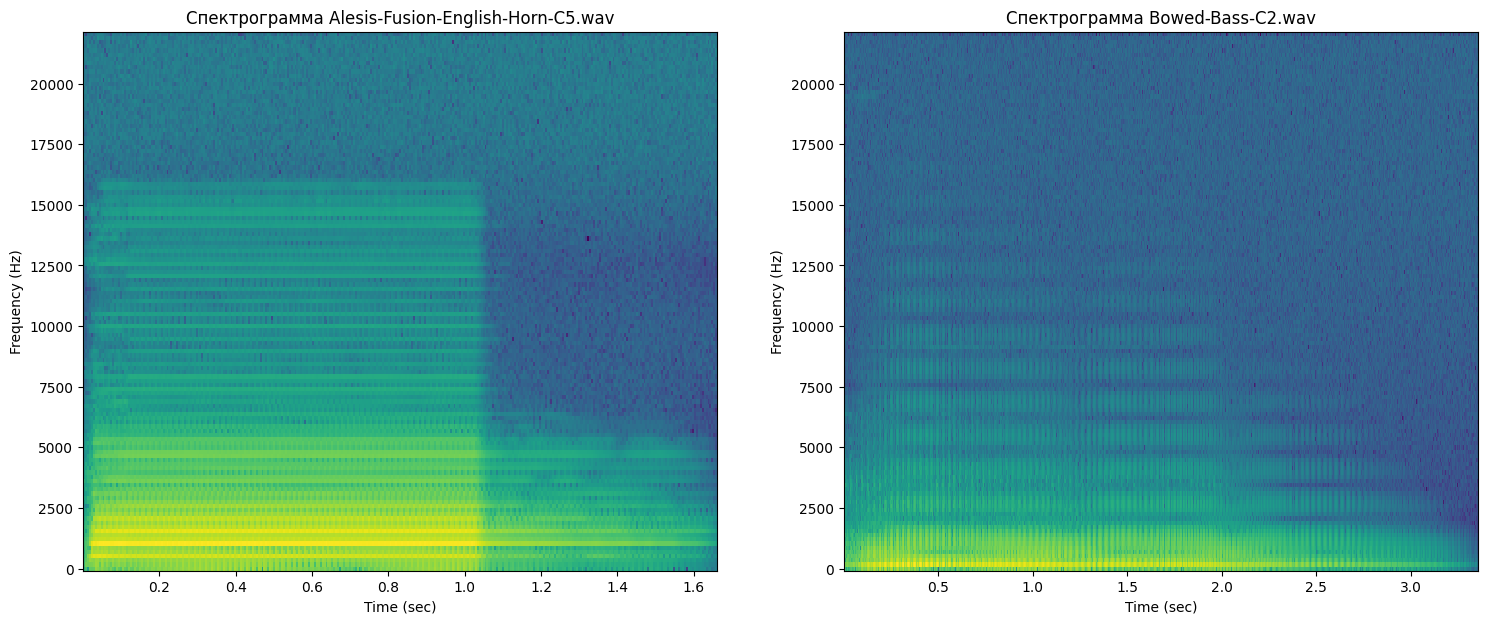

In [30]:
names = ['Alesis-Fusion-English-Horn-C5.wav', 'Bowed-Bass-C2.wav']

plt.figure(figsize=(18, 7))
for i in range(len(datas)):
    s = rates[i]

    fr, tm, spgram = signal.spectrogram(datas[i],s)
    lspg = np.log(spgram)
    
    plt.subplot(1, 2, i+1)
    plt.pcolormesh(tm,fr,lspg,shading='auto')
    plt.title(f'Спектрограмма {names[i]}')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')


Видно, что звуки достаточно отличаются друг от друга по многоим показателям. Хотя мел-кепстральные коэффициенты у них схожи за исключением первых нескольких.